required:
- amore_data_detected.pkl ( amore_data_detected.json )
- model.pt

# 1. Import Packages / Datasets

In [194]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
from ast import literal_eval
import torch
import konlpy
import datetime
from datetime import date

from tqdm import tqdm
from kss import split_sentences
import re
import emoji
from soynlp.normalizer import repeat_normalize

- `df_whole` : 전체 일자에 해당하는 df
- `df` : CBS 계산에 사용되는 일자에 해당하는 df
    - ( default : `window_size` = 50 )

In [195]:
df_whole=pd.read_json('amore_data_detected_bert.json')
#### 지우기
df_whole['review_split_string']=df_whole['review_split'].copy()
df_whole['review_split']=df_whole['review_split_string'].apply(literal_eval)
print(df_whole.shape)

(50183, 50)


In [196]:
df_whole.prod_nm.value_counts()[0:50]

자연을 닮은 시트마스크 1매                       1948
센슈얼 파우더 매트 5g                         1591
플라워 토너 5종 250ml                       1556
크리미틴트 컬러 밤 인텐스 2.5g                   1339
오가니언스 워터 180ml                        1069
어린쑥 수분진정 크림 50ml                       980
달빛유자 수면팩 60ml                          957
알파인 베리 워터리 크림 50ml                     917
자연을 닮은 핸드크림 50ml                       816
자연을 닮은 립밤                              808
[NEW 컬러 출시]센슈얼 스파이시 누드 밤 3.5g          742
어린쑥 수분진정 토너 150ml                      730
크림 스킨 미스트 120ml                        706
스템Ⅲ 앰플 50ml                            667
로즈워터 토너 패드 40매                         647
리치 포밍 클렌저 200ml                        645
센슈얼 스파이시 누드 볼륨 매트 3.5g                 637
에센셜 립세럼 스틱 3g                          612
오가니언스 에멀젼 150ml                        607
페이셜 마일드 필링 150ml                       534
내추럴 베리 립밤 4g                           531
센텔라 트러블 토너 (150ml/250ml)               516
아로마 바디 스크럽 워시 230ml                    512
모이스춰 플럼핑 듀이

In [197]:
cat_task = {'cat1': 1, 'cat2': 2,'cat3': 3,'cat4': 4,'cat5': 5,'cat6': 6,'cat7': 7,'cat9': 8,'cat10': 9}
cols = ['용량','민감성','향기','커버력','지속력','피부톤',
         '보습감','향','사용감','발림성','세정력', # 10
         '촉촉함','유분기','발색감','제형','보습력']
small_cat_indices = [[1, 10, 11],
                     [1, 6, 7],
                     [1, 8, 9],

                     [3, 4, 5],

                     [4, 5, 11, 12, 13, 14],

                     [4, 8, 13],
                     [4, 8, 13],

                     [2, 1, 0],
                     [2, 1, 0]]
plt.rcParams["font.family"] = 'Malgun Gothic' #윈도우, 구글 콜랩
plt.rcParams['font.size'] = 10

# 3. CBS score

In [198]:
import itertools
from itertools import chain

# Score 1

score 1 : 기본 지표

In [199]:
def S1_number_func(x):
    return(sum([len(x[i].split(' ')) for i in range(len(x))]))

def S1_duplicate_func(x):
    return(len(set(x))/len(x))
    
def NVA(x):    
    total_words=[]
    for i, document in enumerate(list(set(x))):
        okt = konlpy.tag.Okt()
        clean_words = []
        for word in okt.pos(document, stem=True): 
            if word[1] in ['Noun', 'Verb', 'Adjective']: 
                clean_words.append(word[0])
        total_words.append(clean_words)
    result = []
    for x in total_words:
        result.extend(x)
    return result


def S1_diversity_func(NVA):  
    return(len(set(NVA))/len(NVA))
    


def s1_recency_func(x,date):
    return((date-x.date()).days)

def S1_recency_func(x,max_date,window):
    """
    max=50 ( 50,49,,...1 )
    ----------------------------------------
    50,49,48,47,46 .... (max-0)~(max-window+1)
    49,48,47,46,45 .... (max-1)~(max-window+0)
    48,47,46,45,44 .... (max-2)~(max-window-1)
    ...
    5,4,3,2,1 ...,,,,,,. (max-45)~(max-window-44)
    ----------------------------------------
    max-45가 window가 될 때 까지
    """
    lower = max_date
    upper = max_date-window+1
    lower_sign=(x<=lower)
    upper_sign=(x>=upper)
    sign=lower_sign*upper_sign
    return sign

def s1_recency_list_func(prod_nm):
    tmp=S1_recency[S1_recency['prod_nm']==prod_nm]
    MA_list=[]
    for i in date_range:
        window_count = len(tmp['s1_recency'][tmp['s1_recency'].apply((lambda x: S1_recency_func(x,max_date-i,recency_window)))>0])
        window_count_mean = window_count/recency_window
        MA_list.append(window_count_mean)
    return MA_list

In [200]:
#today=date.today()
today=datetime.date(2021,8,1)

df_whole['s1_recency']=df_whole['date'].apply((lambda x: s1_recency_func(x,today)))
df_whole['brand_big_category'] = df_whole[['brand', 'big_category']].agg('-'.join, axis=1)

In [201]:
CBS_window=50
recency_window=5

recent=pd.Series(df_whole['s1_recency']<=CBS_window)
recent_idx=recent[recent].index
del recent

In [202]:
recent_idx

Int64Index([   22,    23,    24,    25,    26,    35,    60,    61,    76,
               77,
            ...
            48415, 48416, 48417, 48418, 48419, 48420, 48421, 48422, 48423,
            48424],
           dtype='int64', length=3433)

In [203]:
df=df_whole.loc[recent_idx]
prod_name=df['prod_nm'].unique()

In [204]:
df['s1_length']=df['review_split'].apply(len)
df['s1_number']=df['review_split'].apply(S1_number_func)
df['s1_duplicate']=df['review_split'].apply(S1_duplicate_func)

nva=df['review_split'].apply(NVA)
df['S1_diversity']=nva.apply(S1_diversity_func)
df['S1_number_discounted']=df['s1_number']*df['s1_duplicate']

In [205]:
S1_cols=df.columns[df.columns.str.contains('S1')]

In [206]:
S1 = df.groupby('prod_nm')[S1_cols].mean()

In [207]:
S1_recency = df[['prod_nm','s1_recency']]

In [208]:
max_date=S1_recency['s1_recency'].max()
date_range=np.arange(0,max_date-recency_window)

In [209]:
S1['s1_recency_list']=S1.reset_index()['prod_nm'].apply(s1_recency_list_func).values

In [210]:
S1

,S1_diversity,S1_number_discounted,s1_recency_list
prod_nm,,,
UV 쉴드 안티폴루션 선 세럼 SPF 50+ PA++ 50ml,0.827927,30.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
UV 쉴드 에센셜 톤업 선 50ml,0.834627,29.888889,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
UV쉴드 선 스틱 SPF50+PA++++ 20g,0.879895,25.750000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.2, 0.2, ..."
UV쉴드 선 프로텍터 XP SPF 50+ PA++++ 60ml,0.846793,30.466403,"[0.2, 0.2, 0.2, 0.4, 0.4, 0.4, 0.4, 0.4, 0.2, ..."
[1989에디션] 어린쑥 수분진정 앰플세럼 28ml,1.000000,18.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...
피토알렉신 진정 보습 크림 60ml,0.902663,27.600000,"[0.2, 0.2, 0.2, 0.2, 0.2, 0.0, 0.0, 0.0, 0.0, ..."
핸드크림 백은향 40ml,0.915517,31.000000,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
흰감국 광채 선크림 SPF50+/PA++++ 70ml,0.900048,22.600000,"[0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.2, ..."


# Connectivity (구)

In [211]:
nva_list=list(nva)
tmp=list(df_whole['brand_big_category'][recent_idx])

In [212]:
for i in range(len(recent_idx)):
    nva_list[i]=[tmp[i]]+nva_list[i]

In [213]:
u = (pd.get_dummies(pd.DataFrame(nva_list), prefix='', prefix_sep='')
       .groupby(level=0, axis=1)
       .sum())

cooc_mat = u.T.dot(u)
cooc_mat.values[(np.r_[:len(v)], ) * 2] = 0

In [214]:
cooc_mat_wo_weight=cooc_mat.copy()
cooc_mat_wo_weight[cooc_mat_wo_weight>1]=1

In [215]:
conn = cooc_mat.stack()

In [216]:
conn=conn.rename_axis(('source','target')).reset_index(name='weight')

In [217]:
import networkx as nx

In [218]:
G = nx.from_pandas_edgelist(conn,edge_attr=True)

In [219]:
# inverse weight

for u,v,data in G.edges(data=True):
    if 'weight' in data and data['weight']!=0:
        data['inverse']=1/data['weight']
    else:
        data['inverse']=1

In [220]:
conn_seq = nx.betweenness_centrality(G,normalized=False,weight='inverse')

KeyboardInterrupt: 

In [ ]:
conn_seq

## 3-2. score 2 : 종합 감정 지표

In [523]:
model = torch.load('checkpoint39.pt',map_location='cpu')

In [524]:
cols2

Index(['가격', '감촉', '광택', '구성', '디자인', '만족도', '발림', '발색', '보습', '사용감', '색상',
       '성분', '용기', '용량', '제형', '지속', '커버', '트러블', '표현력', '품질', '향기', '효과',
       '휴대성'],
      dtype='object')

In [525]:
cat_task = {'cat1': 1, 'cat2': 2,'cat3': 3,'cat4': 4,'cat5': 5,'cat6': 6,'cat7': 7,'cat9': 8,'cat10': 9}
cols1 = ['용량','민감성','향기','커버력','지속력','피부톤',
         '보습감','향','사용감','발림성','세정력', # 10
         '촉촉함','유분기','발색감','제형']#,'보습력']
cols2= df.columns[25:48]
small_cat_indices = [[1, 10, 11],
                     [1, 6, 7],
                     [1, 8, 9],

                     [3, 4, 5],

                     [4, 5, 11, 12, 13, 14],

                     [4, 8, 13],
                     [4, 8, 13],

                     [2, 1, 0],
                     [2, 1, 0]]

In [526]:
temp_cols=["overall({})".format(i) for i in [-1,0,1]]+[c + '(-1)' for c in cols1]+[c + '(0)' for c in cols1]+[c + '(1)' for c in cols1]+['ATT_'+c for c in cols1]
S23=pd.DataFrame(index=recent_idx,columns=temp_cols)

In [527]:
def softmax(x):
    return (torch.exp(x) / torch.exp(x).sum()).flatten()



def fill_s23(model, df, idicies):
    for ind in tqdm(idicies):
        
        review = torch.FloatTensor( df['embed_sents'][ind])
        num_sents = torch.tensor( len(review) )
        small_task= cat_task[ df['category'][ind] ]
        detect = df['mask'][ind]
        deteted_aspect= df.loc[ind,cols2][ df.loc[ind,cols2] == 1 ].index.values.tolist()
        deteted_aspect_ind = np.array( small_cat_indices[ small_task - 1 ] )[detect].tolist()
        deteted_aspect_target = np.array(cols1)[deteted_aspect_ind].tolist()
        model.eval()
        model.to('cpu')
        with torch.no_grad():
            out = model(review.unsqueeze(0), num_sents.unsqueeze(0))
        tg, ts, a1, a2, a3, a4, a5, a_g = out


        att_a = [a1[:3], a1[3:6],a1[6:], a2, a3, a4[:3], a4[4:], a5[:3], a5[3:]]

        overall_pred = dict( zip( ['5', '4', '1~3'], list(softmax(tg[small_task-1] )[[2,1,0]].data.numpy().round(3)) ) )

        S23.loc[ind,['overall(1)','overall(0)','overall(-1)']]=list(overall_pred.values())

        calibrated_imp = a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() / sum(a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() )
        aspect_imps = dict( zip( deteted_aspect_target, calibrated_imp) )

        for id_, (aspect_ind, aspect_name,aspect_imp) in enumerate(zip(deteted_aspect_ind, deteted_aspect_target,aspect_imps.values())):
        
            a_index = np.where( (np.array(small_cat_indices[small_task-1]) == aspect_ind))[0][0]
            aspect_pred = dict(zip(['1','0', '-1'], list(softmax(ts[small_task-1][a_index] )[[2,1,0]].data.numpy().round(3)) ))
            S23.loc[ind,aspect_name + '(1)']=aspect_pred['1']
            S23.loc[ind,aspect_name + '(0)']=aspect_pred['0']
            S23.loc[ind,aspect_name + '(-1)']=aspect_pred['-1']
            S23.loc[ind,'ATT_'+aspect_name]=aspect_imp



In [528]:
fill_s23(model, df,recent_idx)

100%|██████████████████████████████████████████████████████████████████████████████| 3433/3433 [02:39<00:00, 21.57it/s]


In [529]:
S23_copy = S23.copy()

In [530]:
eps=1
product_info=df[['prod_nm','big_category','brand','rating']]
product_sent_ratio=pd.crosstab(product_info.prod_nm, product_info.rating)
product_sent_ratio+=eps
product_sent_inv_ratio=product_sent_ratio.apply(lambda x : 1/x)
product_sent_inv_ratio=product_sent_inv_ratio.div(product_sent_inv_ratio.sum(axis=1), axis=0)
product_sent_inv_ratio.columns=['W_overall(-1)','W_overall(0)','W_overall(1)']
product_sent_inv_ratio.reset_index(inplace=True)

In [531]:
S23=pd.concat([S23,df['prod_nm']],axis=1)
S2=S23[['overall(-1)','overall(0)','overall(1)','prod_nm']]

In [532]:
S2=pd.merge(S2,product_sent_inv_ratio,on='prod_nm',how='left')

In [533]:
S2['score(-1)']=(S2['overall(-1)']*S2['W_overall(-1)']).astype('float')
S2['score(0)']=(S2['overall(0)']*S2['W_overall(0)']).astype('float')
S2['score(1)']=(S2['overall(1)']*S2['W_overall(1)']).astype('float')

In [534]:
S2=S2[['prod_nm','score(-1)','score(0)','score(1)']]

In [535]:
S2.head()

,prod_nm,score(-1),score(0),score(1)
0,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.181176,0.093824,0.044000
1,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.144118,0.124118,0.039176
2,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.225294,0.099118,0.032941
3,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.207647,0.106765,0.033412
4,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,0.161176,0.107353,0.042471


In [536]:
S2=S2.groupby('prod_nm').mean()[['score(-1)','score(1)']]

(array([  6.,  12.,  22.,  41.,  61., 103.,  70.,  28.,  12.,   3.]),
 array([-0.33457994, -0.28996195, -0.24534395, -0.20072596, -0.15610797,
        -0.11148997, -0.06687198, -0.02225398,  0.02236401,  0.06698201,
         0.1116    ]),
 <a list of 10 Patch objects>)

C:\Users\LSH\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\LSH\Anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


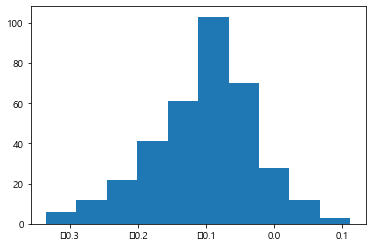

In [537]:
plt.hist(S2['score(1)']-S2['score(-1)'])

In [538]:
S2=pd.DataFrame(S2['score(1)']-S2['score(-1)'],columns=['S2'])

In [539]:
S2.head()

,S2
prod_nm,
UV 쉴드 안티폴루션 선 세럼 SPF 50+ PA++ 50ml,-0.243295
UV 쉴드 에센셜 톤업 선 50ml,-0.127346
UV쉴드 선 스틱 SPF50+PA++++ 20g,-0.053964
UV쉴드 선 프로텍터 XP SPF 50+ PA++++ 60ml,-0.181052
[1989에디션] 어린쑥 수분진정 앰플세럼 28ml,0.111600


### S3

In [591]:
new_S3=S23[['prod_nm']]

W_temp=pd.merge(new_S3,product_sent_inv_ratio,on='prod_nm',how='left')

In [592]:
for col in cols1:
    X_temp=S23[S23.columns[S23.columns.str.contains(col)]]
    X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
    score_plus=np.array(X_temp[col+'(1)'])*np.array(W_temp['W_overall(1)'])
    score_minus=np.array(X_temp[col+'(-1)'])*np.array(W_temp['W_overall(-1)'])
    score_sum=score_plus-score_minus
    new_S3[col]=score_sum

C:\Users\LSH\Anaconda3\lib\site-packages\pandas\core\indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-592-52ab26ad04c8>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_temp.iloc[:,:3]=X_temp.iloc[:,:3].mul(X_temp.iloc[:,3],axis=0)
<ipython-input-592-52ab26ad04c8>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [593]:
new_S3[new_S3.prod_nm=='[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g']

,prod_nm,용량,민감성,향기,커버력,지속력,피부톤,보습감,향,사용감,발림성,세정력,촉촉함,유분기,발색감,제형
22,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,NaN,NaN,NaN,-0.0834634,-0.00795303,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
23,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,NaN,NaN,NaN,-0.0293231,NaN,-0.00394518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
24,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,NaN,NaN,NaN,-0.0379995,-0.0084838,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,NaN,NaN,NaN,-0.0432941,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,[리필] 퍼펙팅 쿠션 SPF50+/PA+++ 15g,NaN,NaN,NaN,-0.0446471,-0.0155294,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [595]:
product_names=list(set(S23['prod_nm']))

In [596]:
S3=pd.DataFrame(index=S2.index,columns=cols1)

In [598]:
for prod_nm in product_names:
    prod_df=new_S3.groupby('prod_nm').get_group(prod_nm)    
    score_x=prod_df.mean()
    w=prod_df.shape[0]-prod_df.iloc[:,1:].isna().sum()
    score_w=w/w.sum()
    score_w=score_w.fillna(0)
    score=(score_x*score_w)
    S3.loc[prod_nm,:]=score

In [600]:
S3=pd.DataFrame(S3.sum(axis=1),columns=['S3'])

In [603]:
S=pd.concat([S1,S2,S3],axis=1)

In [605]:
S.to_csv('CBS.csv')

In [606]:
#S=pd.read_csv('CBS.csv').set_index('prod_nm')

In [2]:
import pandas as pd

In [92]:

S=pd.read_csv('CBS.csv').set_index('prod_nm')

In [93]:
def exp_smoothing(list_,alpha=0.3,eps=1):
    weight_decayed_lists=np.array([alpha*(1-alpha)**(len(list_)-i)*list_[i] for i in range(len(list_))])
    weight_decayed_lists/=(sum(list_)+eps)
    return(sum(weight_decayed_lists))

In [94]:
S['s1_recency_list']=S['s1_recency_list'].apply(literal_eval)

In [95]:
S['s1_recency_list']=S['s1_recency_list'].apply(exp_smoothing,alpha=0.3,eps=1)

In [96]:
S[S.index=='자연을 닮은 시트마스크 1매']

,S1_diversity,S1_number_discounted,s1_recency_list,S2,S3
prod_nm,,,,,
자연을 닮은 시트마스크 1매,0.810591,29.642857,0.021175,-0.239819,-0.070786


In [68]:
def exp_smoothing(list_,alpha=0.3):
    return(sum([alpha*(1-alpha)**(len(list_)-i)*list_[i] for i in range(len(list_))]))

In [69]:
S['s1_recency_list']=S['s1_recency_list'].apply(exp_smoothing,alpha=0.3)

In [19]:
k=[3,4,5]
alpha=0.3

In [20]:
[alpha*(1-alpha)**(len(k)-i)*k[i] for i in range(len(k))]

[0.3086999999999999, 0.5879999999999999, 1.05]

# 끝

In [394]:
S[S['S3']!=0].shape

(54, 5)

In [395]:
S[S['S3']==0].shape

(304, 5)

In [401]:
check=df['prod_nm'].value_counts()

In [406]:
zero_prd=S[S['S3']==0].index
nonzero_prd=S[S['S3']!=0].index
print(len(zero_prd),len(nonzero_prd))

304 54


In [408]:
zero_ls=[]
nonzero_ls=[]
for prd in zero_prd:
    zero_ls.append(check[prd])
    
for prd in nonzero_prd:
    nonzero_ls.append(check[prd])

In [378]:
temp=temp.drop('ATT_커버력',axis=1)

In [382]:
temp=temp['커버력(1)']-temp['커버력(-1)']

In [384]:
new_S3['커버력']=temp

# 기타

In [20]:
# FUNCTION 
def softmax(x):
    return (torch.exp(x) / torch.exp(x).sum()).flatten()

def test_result(model, df, ind = None):
    if ind == None:
        ind = np.random.randint(len(df))
    print(ind)

    review = torch.FloatTensor( df['embed_sents'][ind])
    num_sents = torch.tensor( len(review) )

    review_txt = df['review_split_string'][ind]
    small_task= cat_task[ df['category'][ind] ]
    detect = df['mask'][ind]
    deteted_aspect= df.iloc[ind,25:48][ df.iloc[ind, 25:48] == 1 ].index.values.tolist()
    deteted_aspect_ind = np.array( small_cat_indices[ small_task - 1 ] )[detect].tolist()
    deteted_aspect_target = np.array(cols)[deteted_aspect_ind].tolist()
    aspect_gt = dict( df.iloc[ind,:16][small_cat_indices[ small_task-1]] )
    rating_gt = df['rating'][ind]
    brand = df['brand'][ind]
    product = df['prod_nm'][ind]

    model.eval()
    model.to('cpu')
    with torch.no_grad():
        out = model(review.unsqueeze(0), num_sents.unsqueeze(0))
    tg, ts, a1, a2, a3, a4, a5, a_g = out
    
    print(small_task)

    att_a = [a1[:3], a1[3:6],a1[6:], a2, a3, a4[:3], a4[4:], a5[:3], a5[3:]]

    overall_pred = dict( zip( ['5', '4', '1~3'], list(softmax(tg[small_task-1] )[[2,1,0]].data.numpy().round(3)) ) )
    overall_argmax = str(np.array(['1~3', '4', '5'][ softmax(tg[small_task-1]).argmax().numpy()]))

    calibrated_imp = a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() / sum(a_g[small_task-1].flatten()[[df['mask'][ind]]].numpy() )
    aspect_imp = dict( zip( deteted_aspect_target, calibrated_imp) )

    print('*'* 15 + '  제품  ' + '*'*20)
    print(f'브랜드:{brand}\n제품:{product}\n')
    print('*'* 15 + '  고객이 남긴 정보  ' + '*'*20)
    print(f'[1] 전체평점(gt):{rating_gt}\n[2] 속성별평점(gt):{aspect_gt}\n[3] 리뷰:\n{review_txt}')
    print('\n' + '*'* 15 + '  분석 결과  ' + '*'*20)
    print(f'[4] 발견된 속성:{deteted_aspect}')
    print(f'[4-1] 목표 속성:{deteted_aspect_target}')
    print(f'[5] 전체 예측 평점 : {overall_argmax} (예측 확률 {overall_pred})')
    print(f'[6] 속성별 예측 평점 및 중요도')
    print(f'[6-1] 중요도: {aspect_imp}')
    for id_, (aspect_ind, aspect_name) in enumerate(zip(deteted_aspect_ind, deteted_aspect_target)):
        a_index = np.where( (np.array(small_cat_indices[small_task-1]) == aspect_ind))[0][0]
        aspect_pred = dict(zip(['1','0', '-1'], list(softmax(ts[small_task-1][a_index] )[[2,1,0]].data.numpy().round(3)) ))
        aspect_pred_argmax = str(np.array(['-1','0', '1'])[ softmax(ts[small_task-1][a_index]).argmax().numpy() ])
        print(f'[6-2] {aspect_name}: {aspect_pred_argmax} (예측 확률 {aspect_pred})')

    print('\n[7] Attention')
    parse = literal_eval(review_txt)
    att_ = torch.stack( att_a[small_task -1] ).squeeze(1)[df['mask'][ind]].numpy()
    d = pd.DataFrame(data = att_.T,index = parse, columns=deteted_aspect_target) 

    f, ax = plt.subplots(figsize=(4,4))

    sns.heatmap(d, vmin=0, vmax=1.0, ax=ax, cmap="OrRd")
    label_y = ax.get_yticklabels()
    plt.setp(label_y, horizontalalignment='right')
    label_x = ax.get_xticklabels()

    plt.setp(label_x, rotation=45, horizontalalignment='right')
    plt.show()

In [21]:
#df

In [22]:
len_3s = list(df['mask'][ df['mask'].apply(lambda x: np.array(x).sum() == 3) ].index)
id_ = len_3s[ np.random.randint(len(len_3s)) ]

5
8
***************  제품  ********************
브랜드:sulhwasoo
제품:핸드워시 백은향 300ml

***************  고객이 남긴 정보  ********************
[1] 전체평점(gt):4
[2] 속성별평점(gt):{'A향기': 0, 'A민감성': 0, 'A용량': 1}
[3] 리뷰:
['300ml용량인데 핸드워시치고는 부피감 무게감이 상당하네요', '설화수 할인쿠폰들이 없어지기전에 사고싶었던 워시 하나 구매해보았어요.', '향은 좋구요', '리필도 팔았으면 좋겠어요', '쿠폰들도 종종 주시면 더 좋을것같아요', '좋은기획구매 감사합니다', '아모레퍼시픽몰']

***************  분석 결과  ********************
[4] 발견된 속성:['가격', '구성', '만족도', '용량', '향기']
[4-1] 목표 속성:['향기', '용량']
[5] 전체 예측 평점 : 5 (예측 확률 {'5': 0.401, '4': 0.379, '1~3': 0.22})
[6] 속성별 예측 평점 및 중요도
[6-1] 중요도: {'향기': 0.5007676, '용량': 0.49923238}
[6-2] 향기: 0 (예측 확률 {'1': 0.232, '0': 0.472, '-1': 0.296})
[6-2] 용량: 1 (예측 확률 {'1': 0.421, '0': 0.39, '-1': 0.189})

[7] Attention


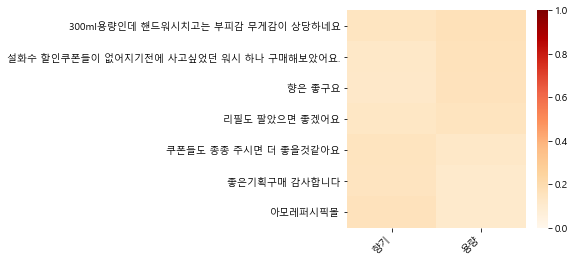

In [34]:
test_result(model, df_whole, ind = 5)